# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()
    
def subSample(I, factor=2):
    """ Array -> Array """
    return I[::factor,::factor]

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx = np.array([[1,0,-1],
                   [2,0,-2],
                   [1,0,-1]])
    Sy = np.array([[1,  2, 1],
                   [0,  0, 0],
                   [-1,-2,-1]])
    img = convolve2d(I,Sx)
    img = convolve2d(img,Sy)
    return img

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    laplacian = np.array([[0, 1,0],
                          [1,-4,1],
                          [0, 1,0]])
    new_img = convolve2d(I, laplacian)
    zero_crossing = np.zeros(I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            neighbor = new_img[i:i+3,j:j+3]
            ma = np.max(neighbor)
            mi = np.min(neighbor)
            if ma > 0 and mi < 0 and ma - mi > s:
                zero_crossing[i][j] = 1
            else:
                zero_crossing[i][j] = 0
    return zero_crossing

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

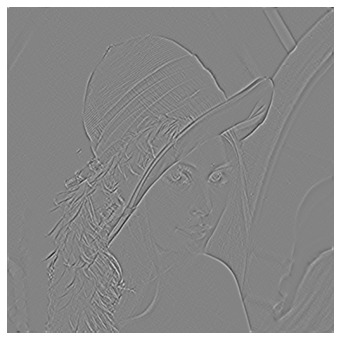

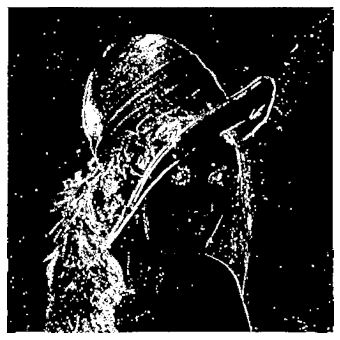

In [4]:
lena = np.array(Image.open('img/lena.png'))
threshold = 100

imshow(SobelDetector(lena, threshold))
imshow(LaplacianDetector(lena, threshold))

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

In [5]:
def Sobelmax(Im):
    derX=convolve2d(Im,np.array([[1,0,-1],
                                 [2,0,-2],
                                 [1,0,-1]]))
    derY=convolve2d(Im,np.array([[1,  2, 1],
                                 [0,  0, 0],
                                 [-1,-2,-1]]))
    norms=np.sqrt(derX**2+derY**2)
    normmax=orientation(derX,derY,norms)
    return nms(norms,normmax)

In [6]:
def Sobelmaxsansnsm(Im):
    derX=convolve2d(Im,np.array([[1,0,-1],[2,0,-2],[1,0,-1]]))
    derY=convolve2d(Im,np.array([[1,  2, 1],[0,  0, 0],[-1,-2,-1]]))
    norms=np.sqrt(derX**2+derY**2)
    normmax=orientation(derX,derY,norms)
    return normmax

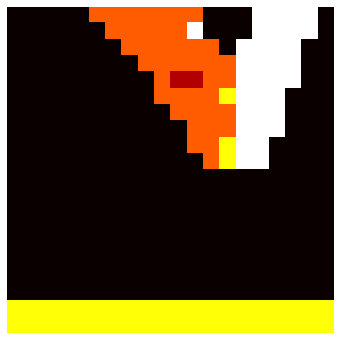

[[0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 4. 4. 4. 4. 0.]
 [0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 4. 0. 0. 0. 4. 4. 4. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 0. 4. 4. 4. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 1. 2. 2. 4. 4. 4. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 3. 4. 4. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 4. 4. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 4. 4. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 3. 4. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3. 4. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

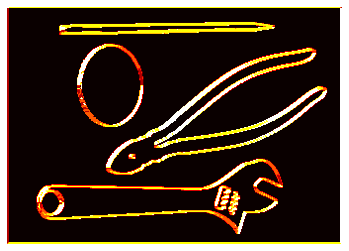

In [7]:
%matplotlib inline

tools = np.array(Image.open('img/tools.png'))

Ig0 = np.zeros(tools.shape)
Ig1 = np.where(Ig0==0, np.pi/4, np.pi/4)
Ig2 = np.where(Ig0==0, np.pi/2, np.pi/2)
Ig3 = np.where(Ig0==0, 3*np.pi/4, 3*np.pi/4)
Ig4 = np.where(Ig0==0, 4*np.pi/4, 4*np.pi/4)

imshow_hot(Sobelmaxsansnsm(tools)[220:240,220:240])
print(Sobelmaxsansnsm(tools)[220:240,220:240])

imshow_hot(Sobelmaxsansnsm(tools))

Explain the different values given to a pixel by `orientation()`:

In [8]:
# Les couleurs sont différentes suivant l'orientation du gradient a chaque pixel de l'image de base.
# L'image retournée par la fonction orientation() est une image d'orientation.
# Les valeurs sont de 1, 2, 3 et 4 suivant l'orientation du gradient, ce qui donne ces differentes couleurs.
# Les pixels noirs à 0 sont des endroits ou l'orientation du gradient est nul.

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [9]:
def Imagepad(I,h):
    f=h.shape[0]
    m,c= I.shape
    res=np.zeros((m+f,c+f))
    b=int(f/2)-1
    for i in range(m+f-1):
        for j in range(c+f-1):
            if i<b or i>m+b-1 or j>c+b-1 or j<b:
                res[i][j]=0
            else:
                res[i][j]=I[i-b][j-b]
    return res

In [10]:
def nms(Ig, Ior):
    h=np.zeros((3,3))
    NewIg=Imagepad(Ig,h)
    NewIg2=np.zeros(Ig.shape)
    for i in range(Ig.shape[0]):
        for j in range(Ig.shape[1]):
            A=0
            B=0
            Iorij=Ior[i-1,j-1]
            if Iorij==0:
                continue
            if Iorij==1:
                A = NewIg[i, j-1]
                B = NewIg[i, j+1]
            if Iorij==2:
                A = NewIg[i-1, j+1]
                B = NewIg[i+1, j-1]
            if Iorij==3:
                A = NewIg[i+1, j]
                B = NewIg[i-1, j]
            if Iorij==4:
                A = NewIg[i-1,j-1]
                B = NewIg[i+1,j+1]
            if max(Ig[i,j],A,B) == Ig[i,j]:
                NewIg2[i,j] = Ig[i,j]
    return NewIg2

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


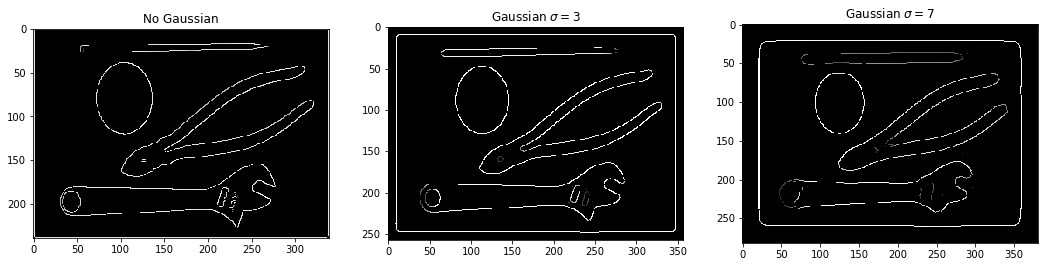

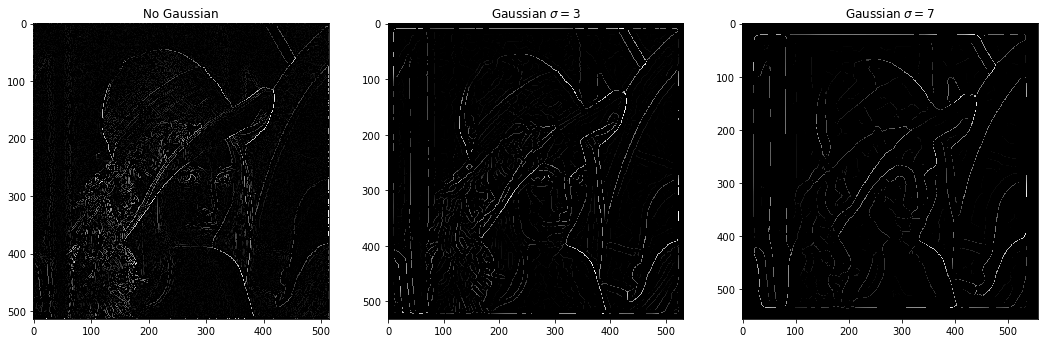

In [11]:
%matplotlib inline

sigma = 5
tools = np.array(Image.open('img/tools.png'))
lena = np.array(Image.open('img/lena.png'))

toolNoGaussian = Sobelmax(tools)
toolGaussian3 = Sobelmax(convolve2d(tools,gaussianKernel(3)))
toolGaussian7 = Sobelmax(convolve2d(tools,gaussianKernel(7)))

lenaNoGaussian = Sobelmax(lena)
lenaGaussian3 = Sobelmax(convolve2d(lena,gaussianKernel(3)))
lenaGaussian7 = Sobelmax(convolve2d(lena,gaussianKernel(7)))

niceDisplay14([toolNoGaussian,toolGaussian3,toolGaussian7],["No Gaussian", "Gaussian $\sigma=3$", "Gaussian $\sigma=7$"])
niceDisplay14([lenaNoGaussian,lenaGaussian3,lenaGaussian7],["No Gaussian", "Gaussian $\sigma=3$", "Gaussian $\sigma=7$"])

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

In [12]:
# Sans sigma, nous pouvons voir sur les deux images (mais plus sur Lena) que les zones bruyantes affectent le contour.
# Les zones bruyantes sont les zones de hautes fréquences (par exemple les cheveux).
# Avec un sigma positif, nous observons que les zones de hautes fréquences sont moins détectées que la normale (car un filtre 
# gaussien est un filtre passe-bas). 
# Plus le sigma augmente, moins la zone est bruyante et moins les contours sont précis, mais plus ils sont débruités.

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

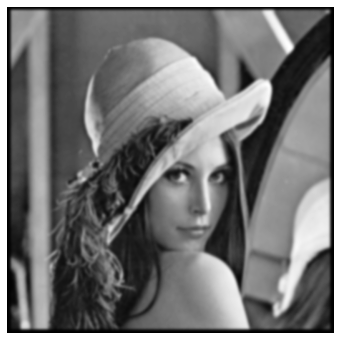

In [13]:
sigma = 2
lena = np.array(Image.open('img/lena.png'))
lena_gauss = convolve2d(lena, gaussianKernel(sigma))
imshow(lena_gauss)

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

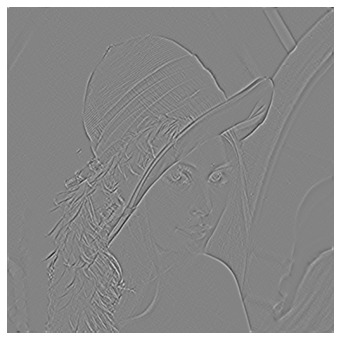

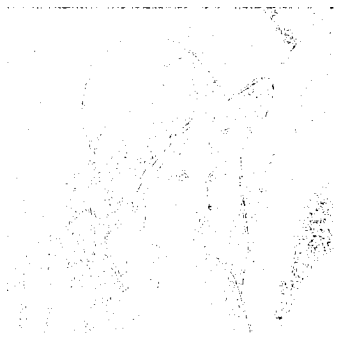

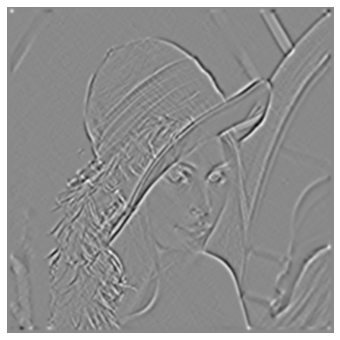

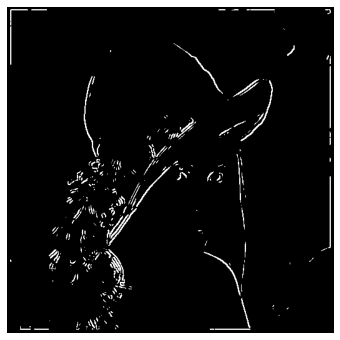

In [14]:
threshold_laplacian = 10
threshold_sobel = 200
imshow(SobelDetector(lena, threshold_sobel))
imshow(LaplacianDetector(lena, threshold_laplacian))
imshow(SobelDetector(lena_gauss, threshold_sobel))
imshow(LaplacianDetector(lena_gauss, threshold_laplacian))

In [15]:
# Avec SobelDetector() :
# On voit que les contours de l'image convolé avec un filtre gaussien ressortent beaucoup plus.
# Certains contours qui étaient peu présent sans convolution avec le filtre gaussien apparaissent.
# Les contours semblent cependant un peu moins précis.

# Avec LaplacianDectector() :
# Il y a une grand difference entre les contours de l'image avec application du filtre gaussien.
# Par exemple, au niveau des yeux, on voit bien mieux les details.
# Les contours sont tous plus précis et plus visible que sans convolution avec filtre gaussien.
# Quelques détails de contours (probablement du bruit) ont disparu comme en bas a droite de l'image.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

In [ ]:
n = 9
sigma_tab = np.arange(0.3, 2.7, 0.3)
lena = np.array(Image.open('img/lena.png'))

fig=plt.figure(figsize=(15,15))
for i in range(1,n+1):
    fig.add_subplot(int(np.sqrt(n)),int(np.sqrt(n)),i)
    lena_gauss_tmp = convolve2d(lena, gaussianKernel(sigma_tab[i-1]))
    lena_tmp = LaplacianDetector(lena_gauss_tmp, threshold_laplacian)
    plt.title('Sigma: {}'.format(sigma_tab[i-1]))
    plt.imshow(lena_tmp)

In [ ]:
n = 9
sigma_tab = np.arange(0.3, 2.7, 0.3)
lena = np.array(Image.open('img/lena.png'))

fig=plt.figure(figsize=(15,15))
for i in range(1,n+1):
    fig.add_subplot(int(np.sqrt(n)),int(np.sqrt(n)),i)
    lena_gauss_tmp = convolve2d(lena, gaussianKernel(sigma_tab[i-1]))
    lena_tmp = SobelDetector(lena_gauss_tmp, threshold_sobel)
    plt.title('Sigma: {}'.format(sigma_tab[i-1]))
    plt.imshow(lena_tmp)

In [ ]:
# Pour laplacian :
# On voit qu'avec un sigma inférieur à 1, il y a beaucoup de bruits et ce n'est pas très efficace.
# Avec un sigma entre 1 et 2, on recupere les contours, plus ou moins bruités et précis.
# Au dessus de 2.7 on ne recupere presque plus de contours.
# Les contours semblent s'affiner lorsque l'on augmente la valeur de sigma.

# Pour sobel :
# On voit qu'on recupere les contours correctement avec un sigma variant entre 0 et 2.7.
# Quand le sigma est faible, les contours sont très précis au niveau de la localisation.
# Plus le sigma augmente, plus la localisation perd de sa précision.
# Les contours sont cependant plus marqué lorsque l'on augmente sigma.

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

In [ ]:
threshold_enhancer = 70
threshold_laplacian = 20
sigma = 0.1

def contrastEnhancer(I, s):
    """ Array*double -> Array """
    contrast_enhancer = np.array([[ 0,-1, 0],
                          [-1, 5,-1],
                          [ 0,-1, 0]])
    return convolve2d(I, contrast_enhancer)

lena_enhanced = contrastEnhancer(lena, threshold_enhancer)
lena_gauss = convolve2d(lena, gaussianKernel(sigma))

lena_tmp = SobelDetector(lena_enhanced, threshold_sobel)
lena_tmp_gauss = SobelDetector(lena_gauss, threshold_sobel)
lena_tmp_2 = LaplacianDetector(lena_enhanced, 150)
lena_tmp_gauss_2 = LaplacianDetector(lena_gauss, threshold_laplacian)
    
imshow(lena, "Lena")
imshow(lena_tmp_gauss, "Lena edge gauss sobel")
imshow(lena_tmp, "Lena edge enhanced sobel")
imshow(lena_tmp_gauss_2, "Lena edge gauss laplacian")
imshow(lena_tmp_2, "Lena edge enhanced laplacian")

In [ ]:
# Il n'y a pas de grande différence lorsque l'on utilise le SobelDetector.
# Lorsque l'on utilise le LaplacianDetector, on doit modifier le threshold de l'image enhanced pour
# obtenir des resultats similaires.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

In [ ]:
img = np.array(lena)

img = convolve2d(img,gaussianKernel(2))

soble = []
sobleText = []

lap = []
lapText = []
for i in range(0,8):
        soble.append(SobelDetector(subSample(lena,2**i),150))
        lap.append(LaplacianDetector(subSample(lena,2**i),150))
        lapText.append(f"Laplacian subsample {2**i}")
        sobleText.append(f"Sobel subsample {2**i}")

In [ ]:
niceDisplay14(soble[0:4], sobleText[0:4])
niceDisplay14(soble[4:],  sobleText[4:])

niceDisplay14(lap[0:4], lapText[0:4])
niceDisplay14(lap[4:],  lapText[4:])

In [ ]:
# Le sous-échantillonnage de l'image fait disparaître beaucoup de données à chaque itération. Les contours sont de moins 
# en moins fins car pixélisé. On perds les informations au niveau de la localisation des contours.
# Nous pouvons voir que le filtre sobel est plus robuste que le filtre laplacien. En effet, avec une valeur de subsample de 4,
# on ne voit presque plus aucune localisation des contours car c'est trop pixelisé. Le detecteur de sobel quant à lui, fonctionne
# correctement pendant 1 voir 2 itérations supplémentaires.

# Exercices supplémentaires :